In [1]:
using QuantumCollocation
using NamedTrajectories
using Optim
using TrajectoryIndexingUtils
using LinearAlgebra
using CairoMakie
using JLD2
using Revise
using ForwardDiff
using Distributions
using Plots

includet("../../SVD_RL_Methods.jl")

In [2]:
const Units = 1e9
const MHz = 1e6 / Units
const GHz = 1e9 / Units
const ns = 1e-9 * Units
const μs = 1e-6 * Units
;

In [3]:
# Operators
const Paulis = Dict(
    "I" => Matrix{ComplexF64}([1 0; 0 1]),
    "X" => Matrix{ComplexF64}([0 1; 1 0]),
    "Y" => Matrix{ComplexF64}([0 -im; im 0]),
    "Z" => Matrix{ComplexF64}([1 0; 0 -1]),
)

Dict{String, Matrix{ComplexF64}} with 4 entries:
  "Y" => [0.0+0.0im 0.0-1.0im; 0.0+1.0im 0.0+0.0im]
  "Z" => [1.0+0.0im 0.0+0.0im; 0.0+0.0im -1.0+0.0im]
  "I" => [1.0+0.0im 0.0+0.0im; 0.0+0.0im 1.0+0.0im]
  "X" => [0.0+0.0im 1.0+0.0im; 1.0+0.0im 0.0+0.0im]

In [4]:
G = Paulis["Z"]
H_drives = [
     Paulis["X"],Paulis["Y"]
]
system = QuantumSystem(H_drives);
t_f = 5* ns
n_steps = 51
times = range(0, t_f, n_steps)  # Alternative: collect(0:Δt:t_f)
n_controls=1
n_qubits=1;
Δt = times[2] - times[1]

0.1

In [5]:
### Generate Initial Trajectories 
PICO_max_iter = 500

# Shape the cost function with weights on states and controls
Q = 100.
R =1e-2

a_bound = 1.0
dda_bound = 1.0

ops = IpoptOptions()
ops.print_info_string = "yes"
ops.recalc_y = "yes"
ops.recalc_y_feas_tol = 1.0 ##down
ops.print_level = 0

p_op = PiccoloOptions()
p_op.verbose=false
p_op.pade_order=10
p_op.free_time=true
p_op.timesteps_all_equal=true

true

In [6]:
p  =UnitarySmoothPulseProblem(
    system,
    G,
    n_steps,
    Δt;
    ipopt_options = ops,
    piccolo_options=p_op,
    a_bound=a_bound,
    dda_bound=dda_bound,
    Q=Q,
    R=R,
)
solve!(p,max_iter=500)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



In [7]:
p_time = UnitaryMinimumTimeProblem(
    p;
)
solve!(p_time,max_iter=500)

In [8]:
Δt =  p_time.trajectory[:Δt][1]

0.08457393501924301

In [9]:
a  = p_time.trajectory[:a]
dda  = p_time.trajectory[:dda]
data = accel_SVD_rollout(dda,system,n_steps,Δt; weighted_modes=true);

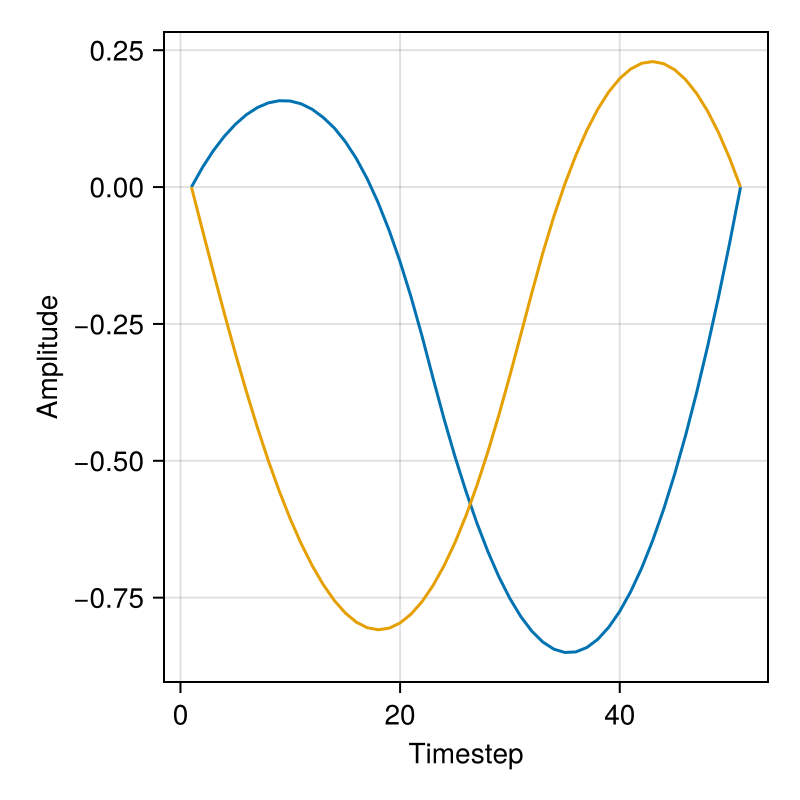

In [10]:
plot_data([a];figsize =(400,400))

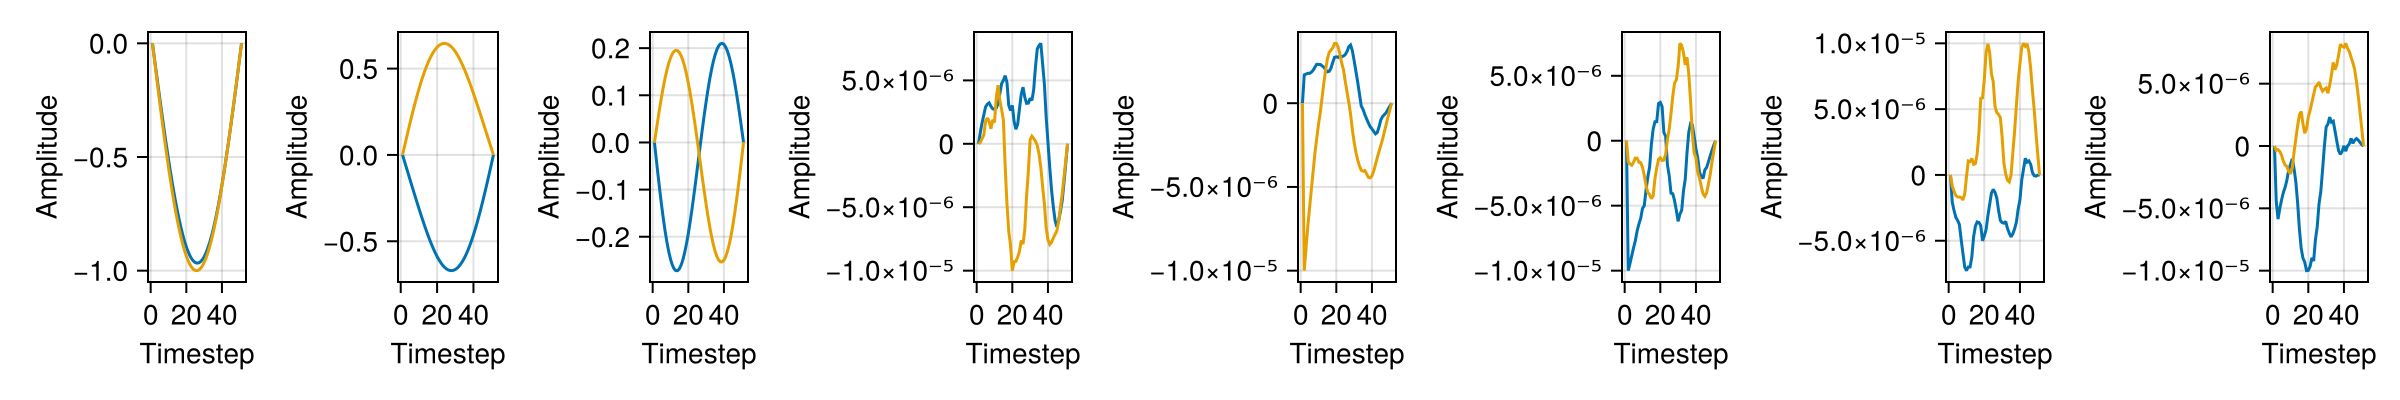

In [11]:
plot_data(data)

In [12]:
full_histories = []
full_values = []
for i ∈ 1:20
    ϵ = rand(Uniform(-0.05,0.05),length(system.H_drives))
    system2 = perturb_system(system,ϵ)
    output = [neadler_mead_opt(trunc,a,data,system2, n_steps,Δt,G;iterations = 2500) for trunc ∈ 1:8]
    history_list = [o[1] for o ∈ output]
    values = [o[2] for o ∈ output]

    push!(full_histories,history_list)
    push!(full_values,values)
end

In [13]:
terminations = reduce(hcat,[[size(i)[1] for i ∈ full_histories[i]] for i ∈ 1:20])
max_lengths = maximum(terminations, dims=2)

padded_histories = deepcopy(full_histories)

for i in padded_histories
    for (j,v) in enumerate(i)
        i[j] = vcat(v,[v[end] for i ∈ 1:(max_lengths[j]-length(v)) ])
    end
end

padded_histories=[[j[i] for j ∈ padded_histories] for i in 1:8];

In [14]:
mean_histories = [mean(padded_histories[i]) for i ∈ 1:8];

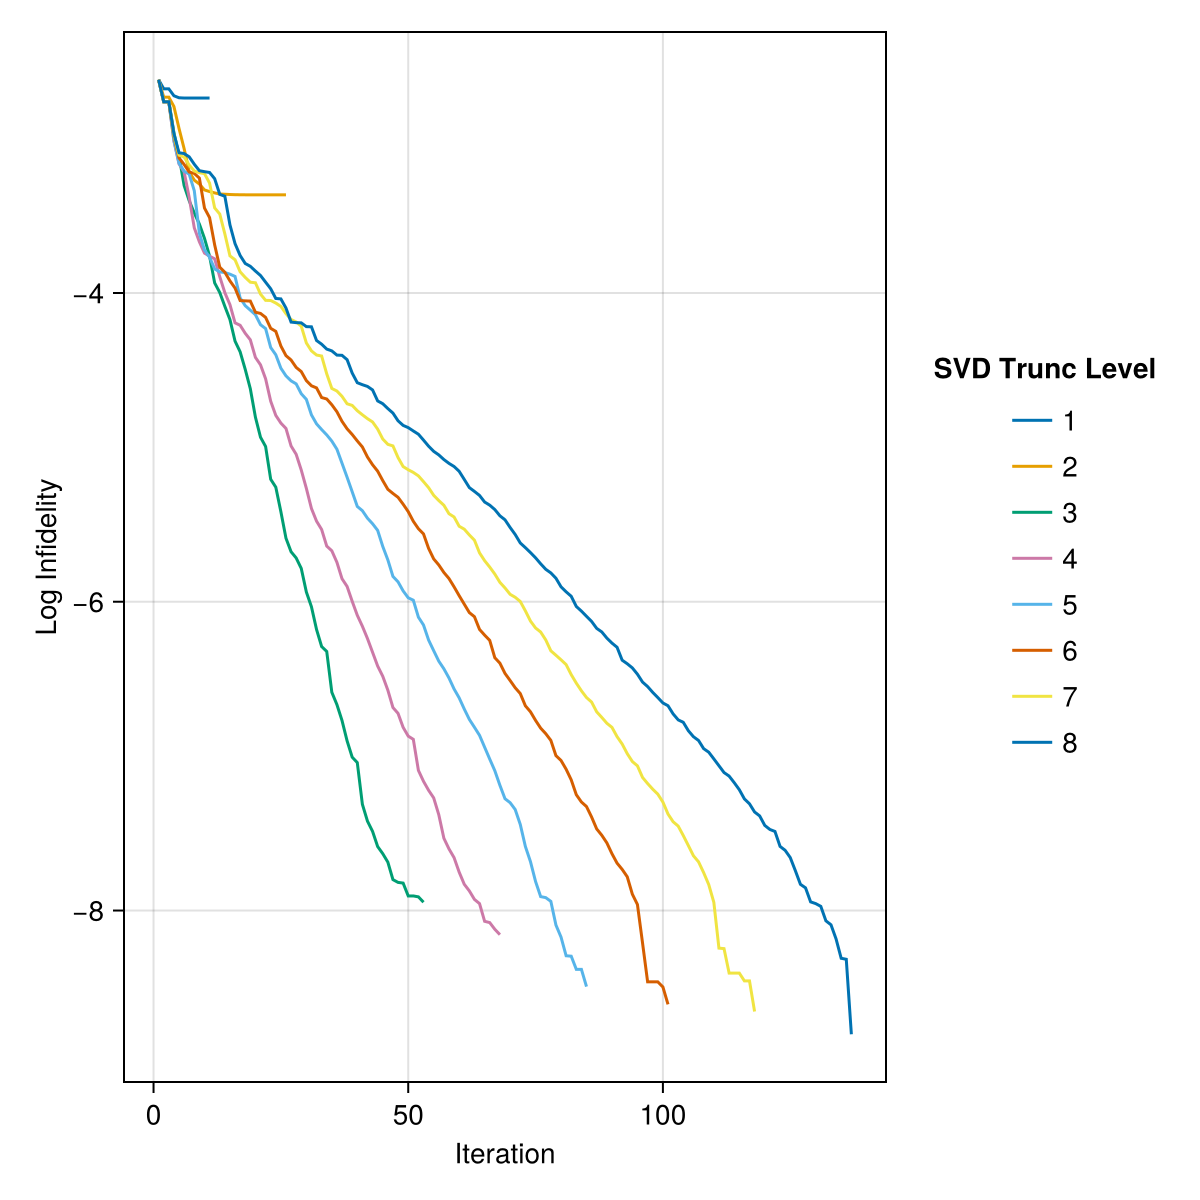

In [15]:
f = Figure(size =(600,600))
ax = Axis(f[1, 1],xlabel="Iteration",ylabel="Log Infidelity")
for (idx,h) ∈ enumerate(mean_histories)
    lines!(log10.(h),label=string(idx))
end
f[1, 2] = Legend(f, ax, "SVD Trunc Level", framevisible = false)
f

In [16]:
mean_finals = [[mean([minimum(i[1:min(end, l)]) for i ∈ padded_histories[n]]) for n ∈ 1:8] for l ∈ 1:maximum(max_lengths)];

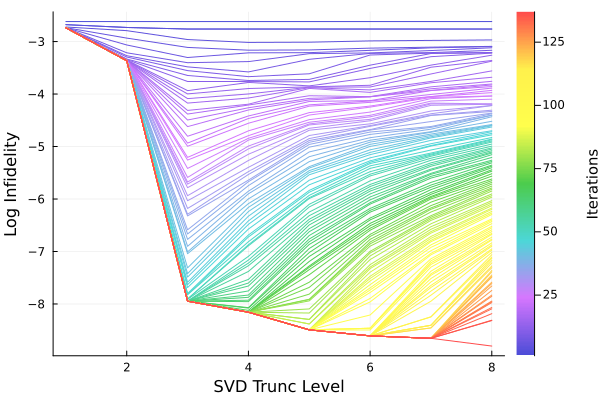

In [17]:
Plots.plot(log10.(reduce(hcat,mean_finals)),color =:lighttest,line_z = (1:maximum(max_lengths))',label=nothing,xlabel="SVD Trunc Level",ylabel="Log Infidelity",colorbar_title="\nIterations",right_margin = 3Plots.mm)